# Anti Collision Tests Environment - openai gym compatible

In [1]:
import numpy as np
import cv2
import math

In [2]:
import matplotlib.pyplot as plt

In [3]:
def show_img(img):
    plt.imshow(img)
    plt.show()
    
def  resize_images(images, f=3):
    big_images = []
    for img in images:
        big_images.append(cv2.resize(img, None, fx=f, fy=f))
    return big_images

In [4]:
plt.rcParams["figure.figsize"]=10,10

#  Some useful functions

In [5]:
def get_dist(obj1, obj2):
    return math.sqrt((obj1[0]-obj2[0])**2 + (obj1[1]-obj2[1])**2)

In [6]:
def get_dist_nearest_obj(s):
    nobjs = int(len(s)/4 - 1)
    ego = s[0:4]
    
    dist_nearest_obj = math.inf
    num_nearest_obj = -1
    
    idx = 4
    for n in range(nobjs):
        obj = s[idx:idx+4]
        dist = get_dist(ego, obj)
        
        if dist < dist_nearest_obj:
            dist_nearest_obj = dist
            num_nearest_obj = n
        idx += 4
    
    return dist_nearest_obj

In [7]:
def get_dist_to_goal(s, goal):
    return get_dist(s[0:4], goal)

# Time To Collision

In [8]:
def get_TTC(ego, obj, radius):
    x1, y1, vx1, vy1 = ego[0], ego[1], ego[2], ego[3]
    x2, y2, vx2, vy2 = obj[0], obj[1], obj[2], obj[3]

    a = (vx1 - vx2) **2 + (vy1 - vy2) **2
    b = 2 * ((x1 - x2) * (vx1 - vx2) + (y1 - y2) * (vy1 - vy2))
    c = (x1 - x2) **2 + (y1 - y2) **2 - radius **2

    if a == 0 and b == 0:
        if c == 0:
            return 0
        else:
            return np.inf

    if a == 0 and b != 0:
        t = -c / b
        if t < 0:
            return np.inf
        else:
            return t

    delta = b **2 - 4 * a * c
    if delta < 0:
        return np.inf

    t1 = (-b - np.sqrt(delta)) / (2 * a)
    t2 = (-b + np.sqrt(delta)) / (2 * a)
    if t1 < 0:
        t1 = np.inf

    if t2 < 0:
        t2 = np.inf

    return min(t1, t2)

In [9]:
def get_smallest_TTC(s):
    radius = 15.0
    ego = s[0:4]
    
    smallest_TTC = np.Inf
    smallest_TTC_obj = -1
    
    idx = 4
    for n in range(int((len(s)-4)/4)):
        obj = s[idx:idx+4]
        TTC = get_TTC(ego, obj, radius)
        
        if TTC < smallest_TTC:
            smallest_TTC = TTC
            smallest_TTC_obj = n
        idx += 4
    
    return smallest_TTC, smallest_TTC_obj

In [10]:
# just checking
obj1 = np.array([0.0, 100, 20, 0])
obj2 = np.array([100, 0.0, 0, 20])
print("dist: ", get_dist(obj1, obj2))
print("TTC: ", get_TTC(obj1, obj2, 15.0))


dist:  141.4213562373095
TTC:  4.4696699141100895


# Driver Models

In [11]:
# Made up ...

class BasicDriverModel():
    # stationarity: 1 is very aggressive, 4 is not very aggressive
    def __init__(self, statio=3.0, dt=0.2):
        self.state = "SPEED_CONSTANT" # SACCEL SCONSTANT
        self.stationarity = statio # every 1, 2, 3 or 4 seconds
        self.accel = 0 # -1 0 1 random uniform on ax
        self.duration = 0
        self.dt = dt
        
    def step(self):
        if self.state == "SPEED_CONSTANT":
            self.duration += self.dt
            if self.duration >= self.stationarity:
                self.accel = np.random.randint(low=-1, high=2)
                self.state = "SPEED_CHANGE"
                self.duration = 0
        elif self.state == "SPEED_CHANGE":
            self.duration += self.dt
            if self.duration >= self.stationarity:
                self.accel = 0
                self.state = "SPEED_CONSTANT"
                self.duration = 0
        return self.accel, self.state  

In [12]:
driver = BasicDriverModel(statio=2.0)
for i in range(20):
    accel, state = driver.step()
    print("accel {} state {}".format(accel, state))

accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel 0 state SPEED_CONSTANT
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE
accel -1 state SPEED_CHANGE


In [13]:
# cf https://en.wikipedia.org/wiki/Intelligent_driver_model
# cf https://github.com/sisl/AutoUrban.jl/blob/master/src/drivermodels/IDMDriver.jl

class IntelligentDriverModel():
    def __init__(self, v_des = 29.0):
        self.a = None # predicted acceleration
        self.sigma = 0 # optional stdev on top of the model, set to zero for deterministic behavior
        
        self.k_spd = 1.0 # proportional constant for speed tracking when in freeflow [s⁻¹]
        
        self.delta = 4.0 # acceleration exponent [-]
        self.T = 1.5 # desired time headway [s]
        self.v_des = v_des # desired speed [m/s], typically overwritten
        self.s_min = 5.0 # minimum acceptable gap [m]
        self.a_max = 3.0 # maximum acceleration ability [m/s²]
        self.d_cmf = 2.0 # comfortable deceleration [m/s²] (positive)
        self.d_max = 9.0 # maximum decelleration [m/s²] (positive)
        
    def step(self, v_ego, v_oth, headway):
        if v_oth is not None:
            assert headway is not None and headway > 0, "v_oth None but headway > 0"
            if headway > 0.0:
                dv = v_oth - v_ego
                s_des = self.s_min + v_ego * self.T - v_ego * dv / (2 * math.sqrt(self.a_max * self.d_cmf))
                
                if self.v_des > 0.0:
                    v_ratio = v_ego / self.v_des
                else:
                    v_ratio = 1.0
                                        
                self.a = self.a_max * (1.0 - v_ratio**self.delta - (s_des / headway)**2)
            # elseif headway > -3.0
            #    model.a = -model.d_max
            else:
                dv = self.v_des - v_ego
                self.a = dv * self.k_spd
        else:
            # no lead vehicle, just drive to match desired speed
            dv = self.v_des - v_ego
            self.a = dv * self.k_spd # predicted accel to match target speed

        if self.a is None:
            print("headway: {} v_oth: {} v_ego: {}".format(headway, v_oth, v_ego))
        assert self.a is not None, "idm accel None"

        self.a = np.clip(self.a, -self.d_max, self.a_max)
        
        if self.sigma > 0:
            self.a += self.sigma * np.random.randn()
            self.a = np.clip(self.a, -self.d_max, self.a_max)
            
        return self.a

In [14]:
driver = IntelligentDriverModel(v_des=30.0)
v_ego = 10
dt = 0.2
for i in range(60):
    a = driver.step(v_ego, None, None)
    v_ego += a*dt
    print("v_ego {} a {}".format(v_ego, a))

v_ego 10.6 a 3.0
v_ego 11.2 a 3.0
v_ego 11.799999999999999 a 3.0
v_ego 12.399999999999999 a 3.0
v_ego 12.999999999999998 a 3.0
v_ego 13.599999999999998 a 3.0
v_ego 14.199999999999998 a 3.0
v_ego 14.799999999999997 a 3.0
v_ego 15.399999999999997 a 3.0
v_ego 15.999999999999996 a 3.0
v_ego 16.599999999999998 a 3.0
v_ego 17.2 a 3.0
v_ego 17.8 a 3.0
v_ego 18.400000000000002 a 3.0
v_ego 19.000000000000004 a 3.0
v_ego 19.600000000000005 a 3.0
v_ego 20.200000000000006 a 3.0
v_ego 20.800000000000008 a 3.0
v_ego 21.40000000000001 a 3.0
v_ego 22.00000000000001 a 3.0
v_ego 22.600000000000012 a 3.0
v_ego 23.200000000000014 a 3.0
v_ego 23.800000000000015 a 3.0
v_ego 24.400000000000016 a 3.0
v_ego 25.000000000000018 a 3.0
v_ego 25.60000000000002 a 3.0
v_ego 26.20000000000002 a 3.0
v_ego 26.800000000000022 a 3.0
v_ego 27.400000000000023 a 3.0
v_ego 27.92000000000002 a 2.5999999999999766
v_ego 28.336000000000016 a 2.0799999999999805
v_ego 28.66880000000001 a 1.6639999999999837
v_ego 28.935040000000008 

# Openai gym Anti Collision Test Env

In [15]:
##################################################################
# Anti Collision Tests env compatible with gym openai interface
##################################################################

# API eg https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

stationarity = 1.0


import gym
from gym import spaces, logger
from gym.utils import seeding

import math
import numpy as np
import cv2
import copy

def draw_arrow(image, p, q, color, arrow_magnitude=5, thickness=1, line_type=4, shift=0):
    # adapted from http://mlikihazar.blogspot.com.au/2013/02/draw-arrow-opencv.html
    # draw arrow tail
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # calc angle of the arrow
    angle = np.arctan2(p[1]-q[1], p[0]-q[0])
    # starting point of first line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle + np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle + np.pi/4)))
    # draw first half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # starting point of second line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle - np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle - np.pi/4)))
    # draw second half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)

# Transition with Constant Acceleration model
def transition_ca(s, a, dt=0.2):
    Ts = np.matrix([[1.0, 0.0, dt,  0.0], 
                [0.0, 1.0, 0.0, dt],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0]])
    Ta = np.matrix([[0.5*dt**2, 0.0],
                [0.0,      0.5*dt**2],
                [dt,       0.0],
                [0.0,      dt]])
    return np.dot(Ts, s) + np.dot(Ta, a)


class ActEnv(gym.Env):
    def __init__(self, nobjs, max_accel=2, dist_collision=10, reward_shaping=True):    
        self.nobjs = nobjs
        self.max_accel = max_accel
        self.dist_collision = dist_collision
        self.reward_shaping = reward_shaping
        
        self.action_space = spaces.Box(low=-self.max_accel, high=self.max_accel, shape=(1,))
        # 1+nobjs: x,y,vx,vy with x,y in [0,200] and vx,vy in [0,40]
        self.observation_space = spaces.Box(low=0.0, high=200.0, shape=((1+nobjs)*4,))
        
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def reset(self):
        self.reward = None
        self.steps_beyond_done = 0
        self.steps = 0
        self.smallest_TTC_obj = -1
        
        self.drivers = []
        
        # x, y, vx, vy
        self.start = np.array([100.0,   0.0,  0.0,  20.0], dtype=int)
        self.goal  = np.array([100.0, 200.0, 0.0, 0.0], dtype=int)
        # states init
        state = ego = self.start
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=0, high=50)
            y = self.np_random.randint(low=25, high=190)
            vx = self.np_random.randint(low=10, high=25)
            vy = self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)
            driver = BasicDriverModel(statio=stationarity)
            self.drivers.append(driver)
        
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=150, high=200)
            y = self.np_random.randint(low=25, high=190)
            vx = - self.np_random.randint(low=10, high=25)
            vy = - self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)
            driver = BasicDriverModel(statio=stationarity)
            self.drivers.append(driver)
            
        print(state)  
        self.s = state
        
        return self.s
    
    # TODO reward shaping and reward basic
    def _reward(self, s, a, sp):
        # Keep track for visualization, plots ...
        self.dist_to_goal = get_dist_to_goal(sp, self.goal)
        self.dist_nearest_obj = get_dist_nearest_obj(sp)
        self.smallest_TTC, self.smallest_TTC_obj = get_smallest_TTC(sp)

        # We are dealiong with 3 types of objectives:
        # - COMFORT (weiht 1)
        # - EFFICIENCY (weight 10)
        # - SAFETY (weight 100)

        r_comfort = r_efficiency = r_safety = 0

        if self.reward_shaping and self.smallest_TTC <= 10.0:
            r_safety += -10 - (10 - self.smallest_TTC) * 10 # between [-100, -10]

        # SAFETY related + terminal state (overwrite)
        if self.dist_nearest_obj <= self.dist_collision:
            r_safety += -1000

        # The faster we go in this test setup
        r_efficiency += a

        if a < -2:
            r_comfort += -1

        # Keep track for visualization, plots ...
        self.r_comfort = r_comfort
        self.r_efficiency = r_efficiency
        self.r_safety = r_safety

        return r_comfort + r_efficiency + r_safety
        
    def render(self):
        pos_left = 40
        #color_text = (255,255,255)
        color_text = (0,0,0)
        img = np.zeros([250, 250, 3],dtype=np.uint8)
        img.fill(255) # or img[:] = 255
        cv2.putText(img, 'Anti Collision Tests', (pos_left, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
        x = self.s[0]; y = self.s[1]; vx = self.s[2]; vy = self.s[3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
        color = (0, 0, 255) # blue
        cv2.circle(img, (x, y), 2, color, -1)
        draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
        cv2.putText(img, str(v) + ' kmh', (x+vx+5, y+vy), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color)
        
        for i in range(self.nobjs):
            if i == self.smallest_TTC_obj:
                color = (255, 0, 0) # red
            else:
                color = (0, 2500, 0) # green
            idx = (i+1)*4
            x = self.s[idx]; y = self.s[idx+1]; vx = self.s[idx+2]; vy = self.s[idx+3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
            cv2.circle(img, (x, y), 2, color, -1)
            draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
            cv2.putText(img, str(v) + ' kmh', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
        
        if self.reward is not None:
            str_reward = "R_com %.2f , R_eff %.2f R_saf %.2f" % (self.r_comfort, self.r_efficiency, self.r_safety)
            cv2.putText(img, str_reward, (pos_left, 205), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
        
            str_safety = "TTC %.2f seconds, D_min %.2f meters" % (self.smallest_TTC, self.dist_nearest_obj)
            cv2.putText(img, str_safety, (pos_left, 215), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color_text)
            
            str_step = "Step %d with action %d reward %.2f" % (self.steps, self.action, self.reward)
            cv2.putText(img, str_step, (pos_left, 225), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,255))
        
        #img = cv2.resize(img, None, fx=20, fy=20)
        #img = cv2.resize(img,(2500, 2500))
        return img
        
    #state, reward, done, info = env.step(action)
    def step(self, action):
        reward = -1; done = False        
        sp = copy.copy(self.s)
        
        s = self.s[0:4]
        a = np.array([0.0, action])
        sp[0:4] = transition_ca(s, a)
        
        idx = 4
        for n in range(self.nobjs):
            s_obj = self.s[idx:idx+4]
            accel, state = self.drivers[n].step() # CALL driver model
            print("OBJ {} accel {} state {}".format(n, accel, state))
            a_obj = np.array([accel, 0.0])
            sp[idx:idx+4] = transition_ca(s_obj, a_obj)
            idx += 4
            
        reward = self._reward(self.s, action, sp)
        
        self.s = sp
        self.action = action
        self.reward = reward
        self.steps += 1
        
        if self.dist_nearest_obj <= self.dist_collision or self.s[1] >= self.goal[1]:
            print("done: dist_nearest_obj {}, y-ego {}".format(self.dist_nearest_obj, self.s[1]))
            done = True
            if self.steps_beyond_done > 0:
                logger.warn("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            
        return self.s, reward, done, {}
    
    def close(self):
        return

In [16]:
env = ActEnv(10)

[100   0   0  20   6  51  10   4  44  65  20   2  41  97  20   3   2 146
  24   4  10  68  19   3 189  94 -23  -2 194  28 -11  -2 196 176 -17  -2
 162  98 -17  -3 179 116 -20  -3]


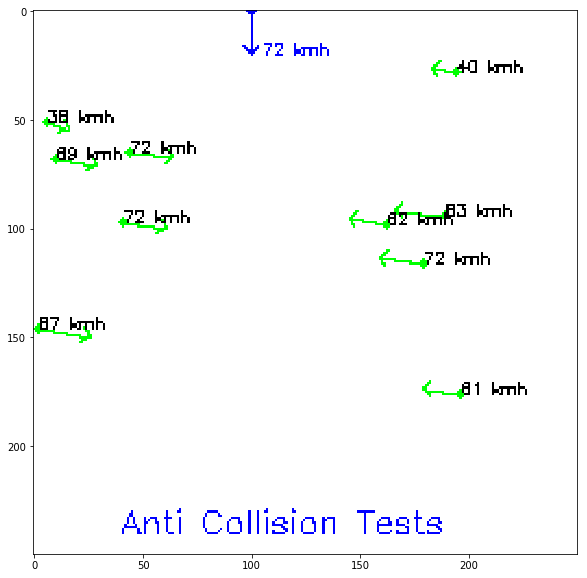

In [17]:
img = env.render()

plt.imshow(img)
plt.show()

In [18]:
pipo = np.arange(20)

In [19]:
max_episodes = 3
max_steps = 20

for episode in range(max_episodes):
    print("====> Start episode {}".format(episode))
    env.reset()
    cumulated_reward = 0
    images = []
    for n in range(max_steps):
        action = 0.0
        state, reward, done, info = env.step(action)
        cumulated_reward += reward
        print("Step {}: action={} reward={} done={}".format(n, action, reward, done)) # PHW DEBUG
        img = env.render()
        images.append(img)
        if done is True:
            print("End of episode {} with cumulated_reward {}".format(episode, cumulated_reward))
            break

====> Start episode 0
[100   0   0  20  44  51  21   0   9 169  10   3   5 141  20   0  18 114
  14   3  17  65  17   0 188 127 -13  -2 157 151 -10   0 187  42 -15  -4
 166  90 -20  -3 171 108 -11  -1]
OBJ 0 accel 0 state SPEED_CONSTANT
OBJ 1 accel 0 state SPEED_CONSTANT
OBJ 2 accel 0 state SPEED_CONSTANT
OBJ 3 accel 0 state SPEED_CONSTANT
OBJ 4 accel 0 state SPEED_CONSTANT
OBJ 5 accel 0 state SPEED_CONSTANT
OBJ 6 accel 0 state SPEED_CONSTANT
OBJ 7 accel 0 state SPEED_CONSTANT
OBJ 8 accel 0 state SPEED_CONSTANT
OBJ 9 accel 0 state SPEED_CONSTANT
Step 0: action=0.0 reward=-90.97216637506574 done=False
OBJ 0 accel 0 state SPEED_CONSTANT
OBJ 1 accel 0 state SPEED_CONSTANT
OBJ 2 accel 0 state SPEED_CONSTANT
OBJ 3 accel 0 state SPEED_CONSTANT
OBJ 4 accel 0 state SPEED_CONSTANT
OBJ 5 accel 0 state SPEED_CONSTANT
OBJ 6 accel 0 state SPEED_CONSTANT
OBJ 7 accel 0 state SPEED_CONSTANT
OBJ 8 accel 0 state SPEED_CONSTANT
OBJ 9 accel 0 state SPEED_CONSTANT
Step 1: action=0.0 reward=-92.916163469983

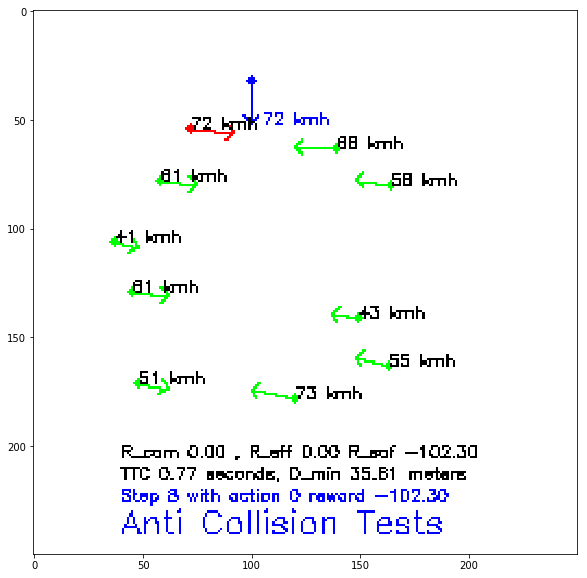

In [20]:
show_img(images[7])

# Visualization

In [21]:
import imageio
from IPython.core.display import HTML

In [22]:
imageio.mimsave('img/visu.gif', images, duration=0.2)
HTML("""<img src="img/visu.gif"/>""")

In [23]:
big_images = resize_images(images, f=2)
imageio.mimsave('img/visu2.gif', big_images, duration=0.2)
HTML("""<img src="img/visu2.gif"/>""")